## sampling RNA, with secondary structure elements to induce graph minor 

#### initialize

In [1]:
%load_ext autoreload
%autoreload 2
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1)
%matplotlib inline

#### GET RNA DATA

In [2]:
from eden.converter.fasta import fasta_to_sequence
import itertools
from eden.converter.fasta import fasta_to_sequence


def rfam_uri(family_id):
    return 'http://rfam.xfam.org/family/%s/alignment?acc=%s&format=fastau&download=0'%(family_id,family_id)
def rfam_uri(family_id):
    return '%s.fa'%(family_id)

def get_sequences(size=9999,withoutnames=False):
    sequences = itertools.islice( fasta_to_sequence("../toolsdata/RF00005.fa"), size)
    if withoutnames:
        return [ b for (a,b) in sequences ]
    return sequences


## TESTING EXTRACTION AND GRAPHMANAGER

DEMONSTRATING GRAPH MANAGER
grammar example 4


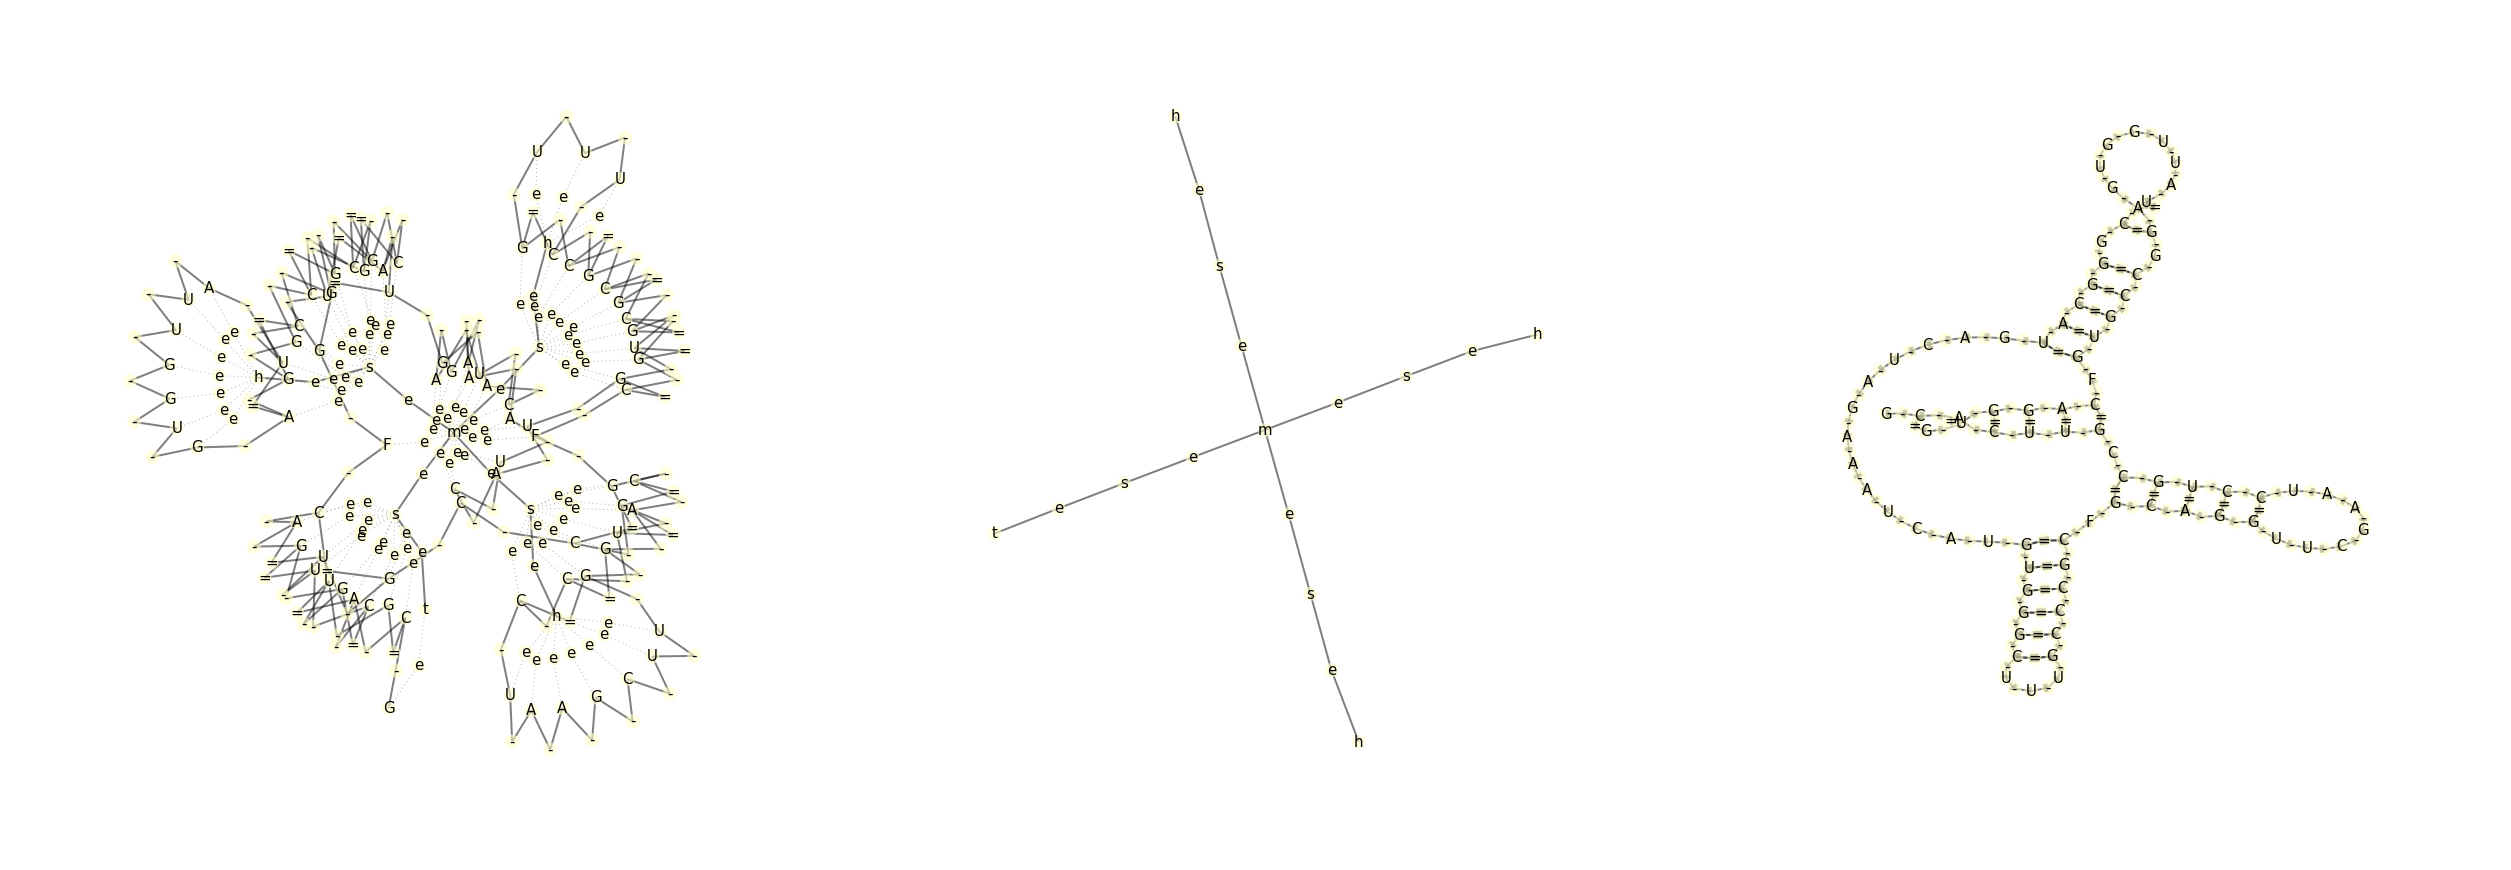

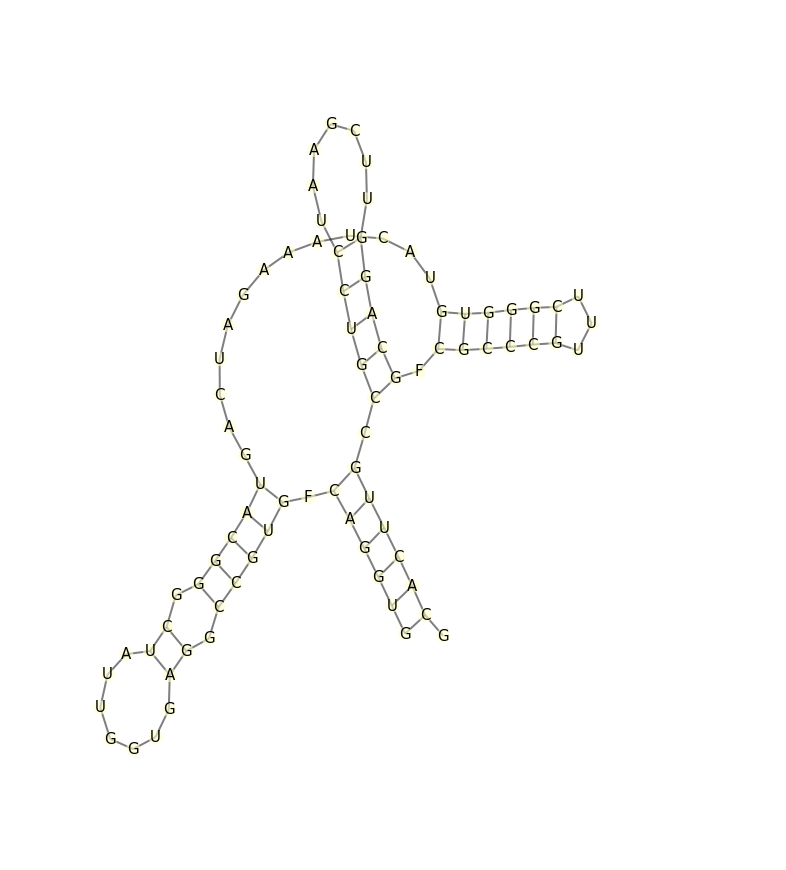

GUGGACFGUGCCGGAGUGGUUAUCGGGCAUGACUAGAAAUCAUGUGGGCUUUGCCCGCFGCAGGUUCGAAUCCUGCCGUUCACG
((((((.(((((.((.......)).))))).............((((((...)))))).(((((.......))))).)))))).


In [3]:
from graphlearn.utils import draw
import graphlearn.abstract_graphs.RNA as rna
from graphlearn.graphlearn import Sampler as GLS
from eden.graph import Vectorizer

vectorizer=Vectorizer()
pp=rna.PreProcessor(ignore_inserts=True)
pp.fit(get_sequences(),vectorizer)
graphmanagers=pp.transform(get_sequences(withoutnames=True)[:20])

print 'DEMONSTRATING GRAPH MANAGER'

for i in [4]:
    print 'grammar example %d' % i
    gm=graphmanagers[i]
    g=gm.graph(nested=True)
    draw.graphlearn([gm.graph(nested=True),gm.abstract_graph(),gm.base_graph()], size = 15,vertex_label = 'label',contract=False)
    draw.graphlearn([gm.base_graph()], size = 15,vertex_label = 'label',contract=True)
    
    print gm.sequence
    print gm.structure

## creating grammar and estimator

In [4]:
%%time
import graphlearn.abstract_graphs.RNA as rna
from  graphlearn.feasibility import FeasibilityChecker as Checker
import graphlearn.estimator as estimator
# not really needed since after refolding we get an RNA
#feasibility=Checker()
#feasibility.checklist.append(rna.is_rna)
graphs = get_sequences(size=100)
estimator=estimator.Wrapper( nu=.33, cv=2, n_jobs=-1)
sampler=rna.AbstractSampler(radius_list=[0,1],
                            thickness_list=[2], 
                            min_cip_count=1, 
                            min_interface_count=2, 
                            preprocessor=rna.PreProcessor(base_thickness_list=[1],ignore_inserts=True), 
                            postprocessor=rna.PostProcessor(),
                            estimator=estimator
                            #feasibility_checker=feasibility
                           )
sampler.fit(graphs,grammar_n_jobs=1,grammar_batch_size=1)
sampler.save('../tmp/rna_ubergrammar.ge')


CPU times: user 22.2 s, sys: 1.32 s, total: 23.5 s
Wall time: 39.2 s


interface id: 192835 [65 options]


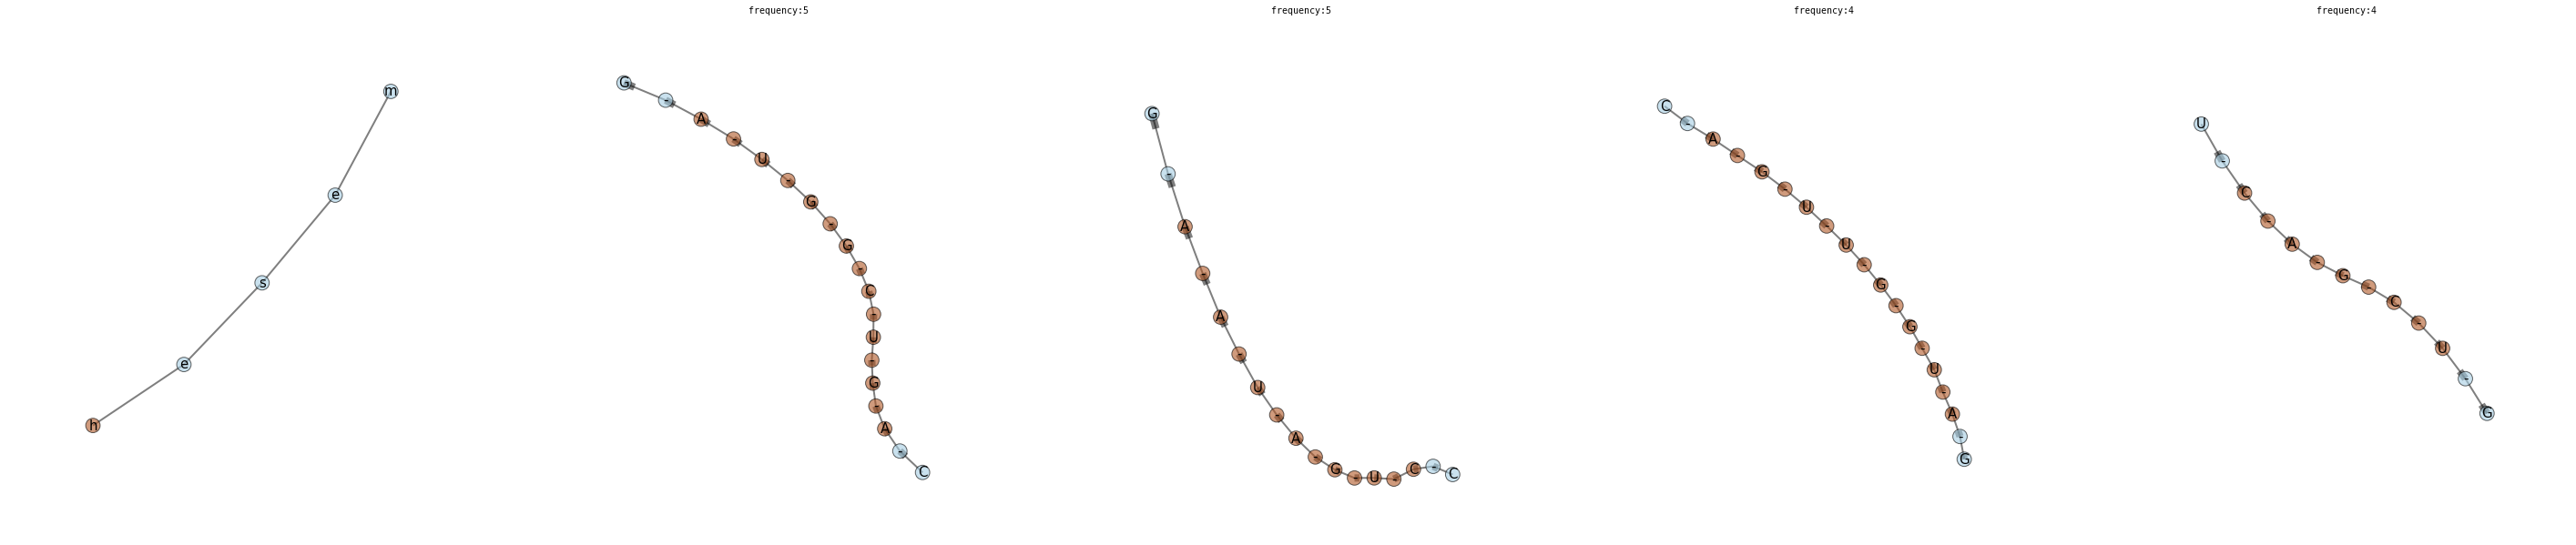

interface id: 355475 [58 options]


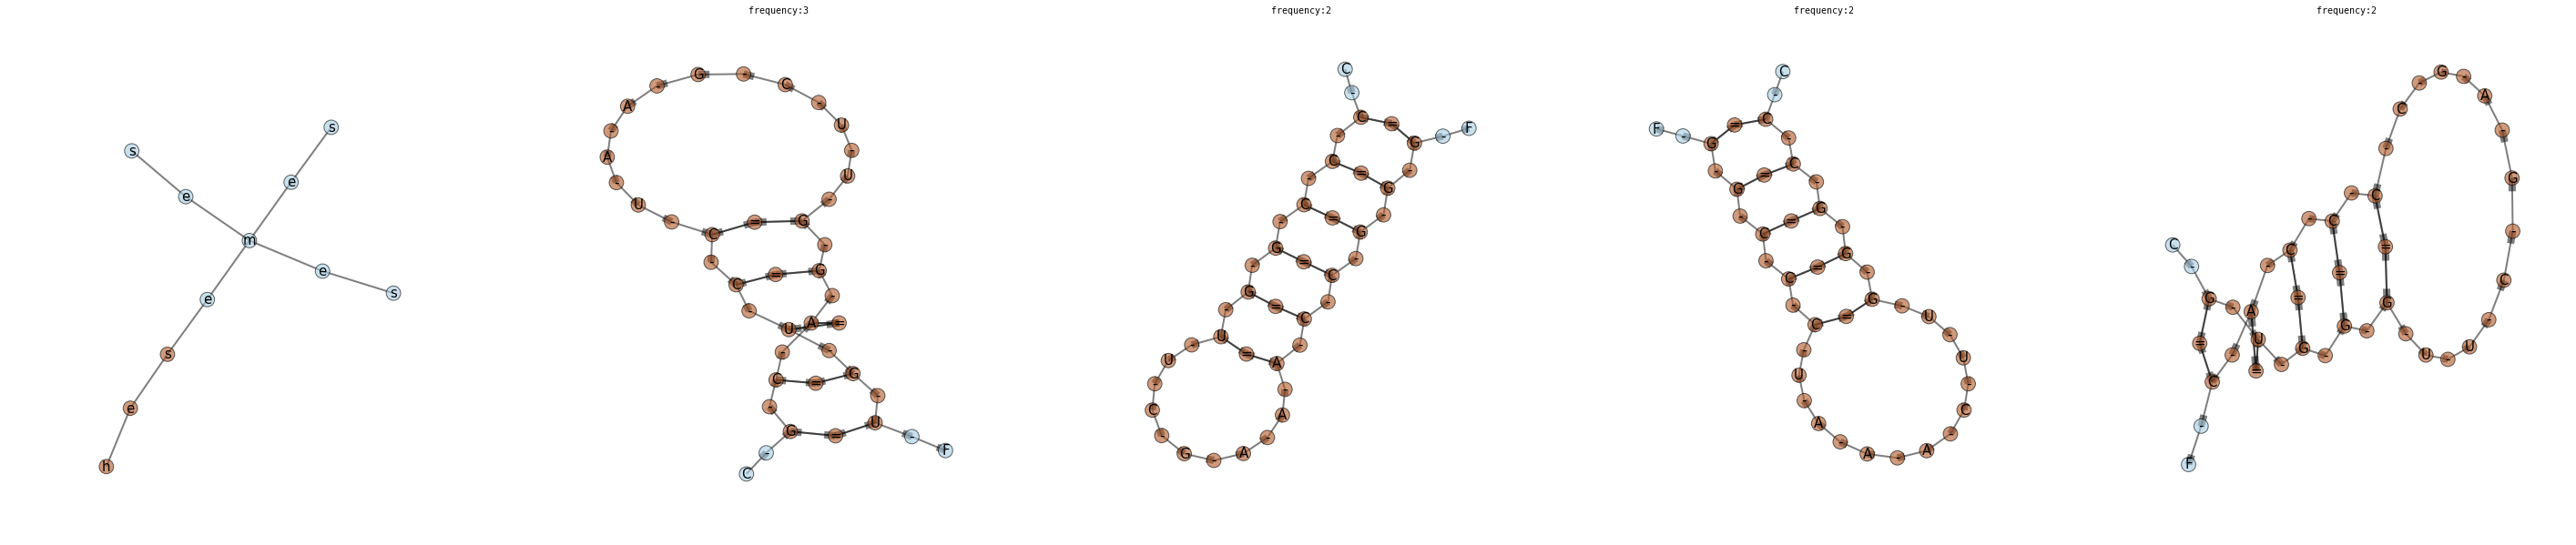

interface id: 353053 [54 options]


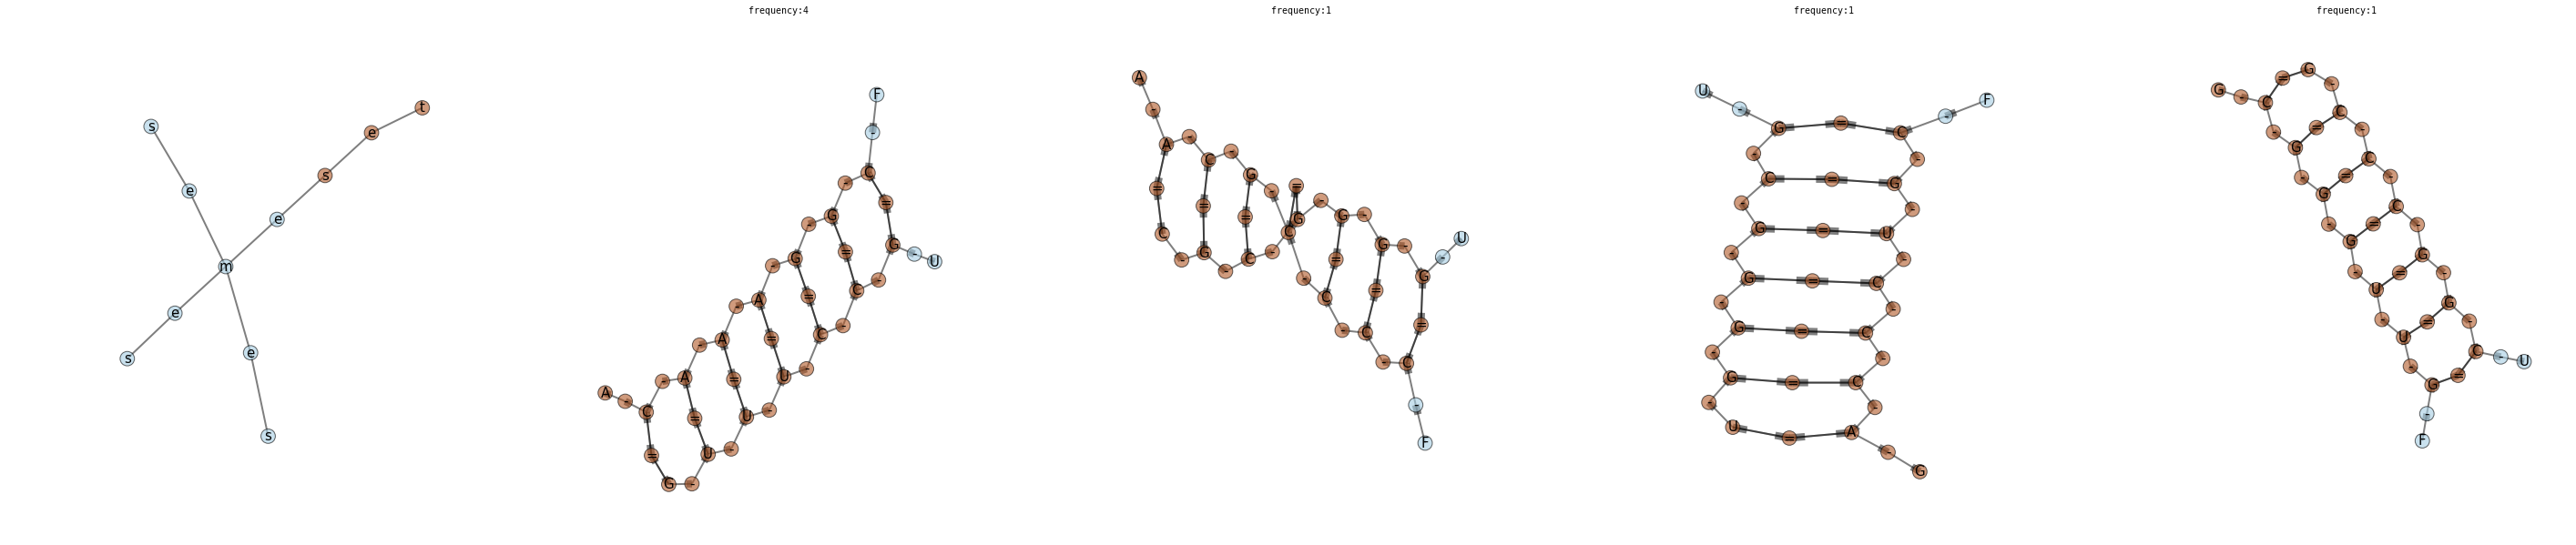

interface id: 902645 [38 options]


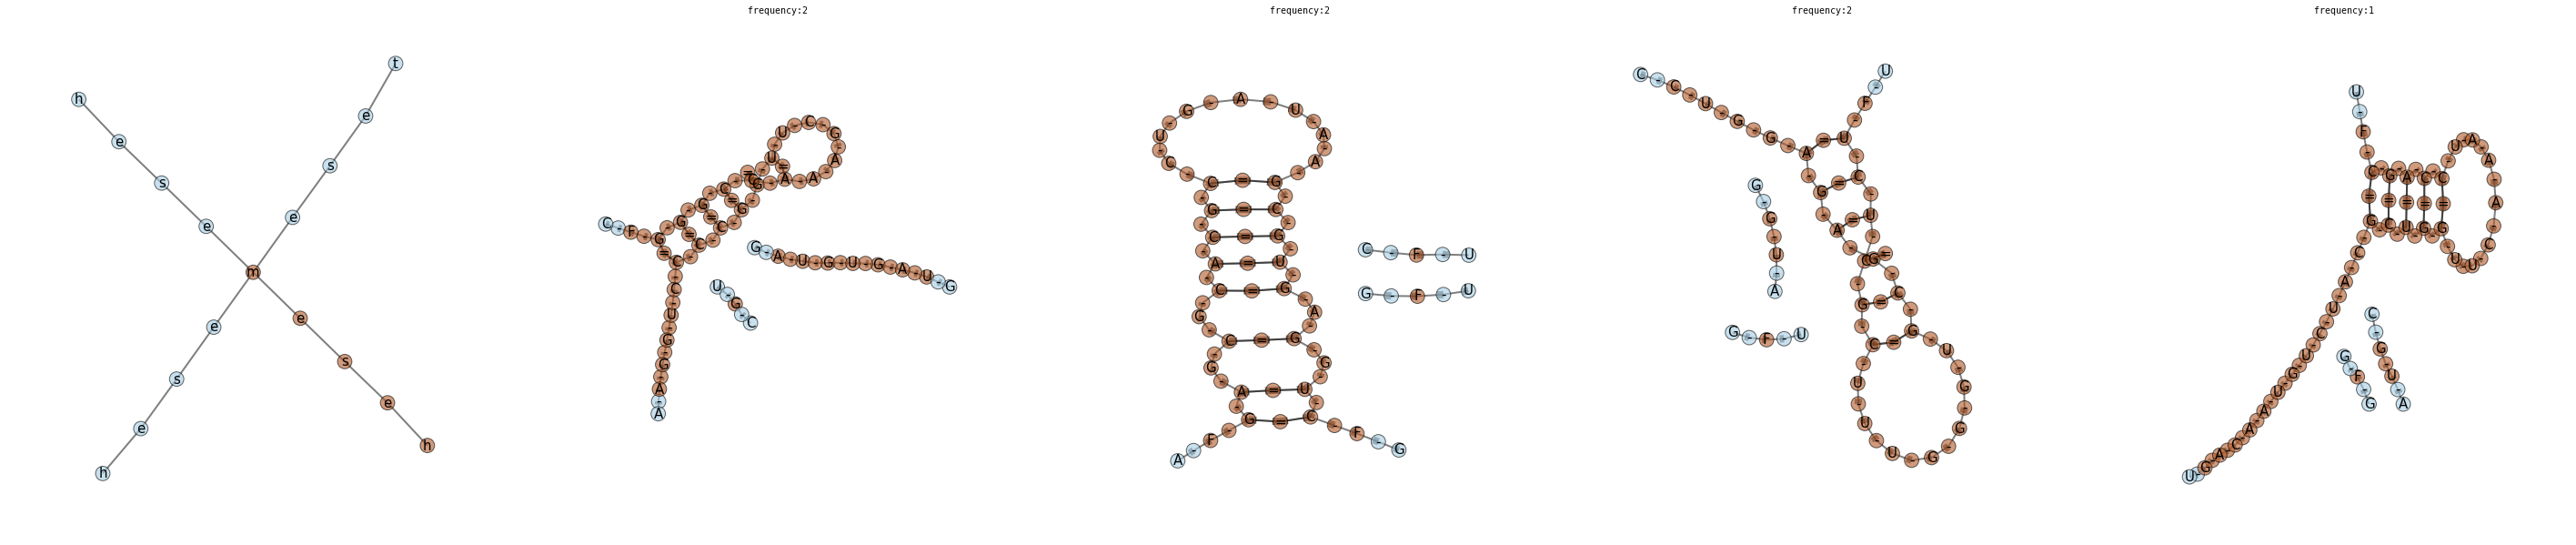

interface id: 53692 [38 options]


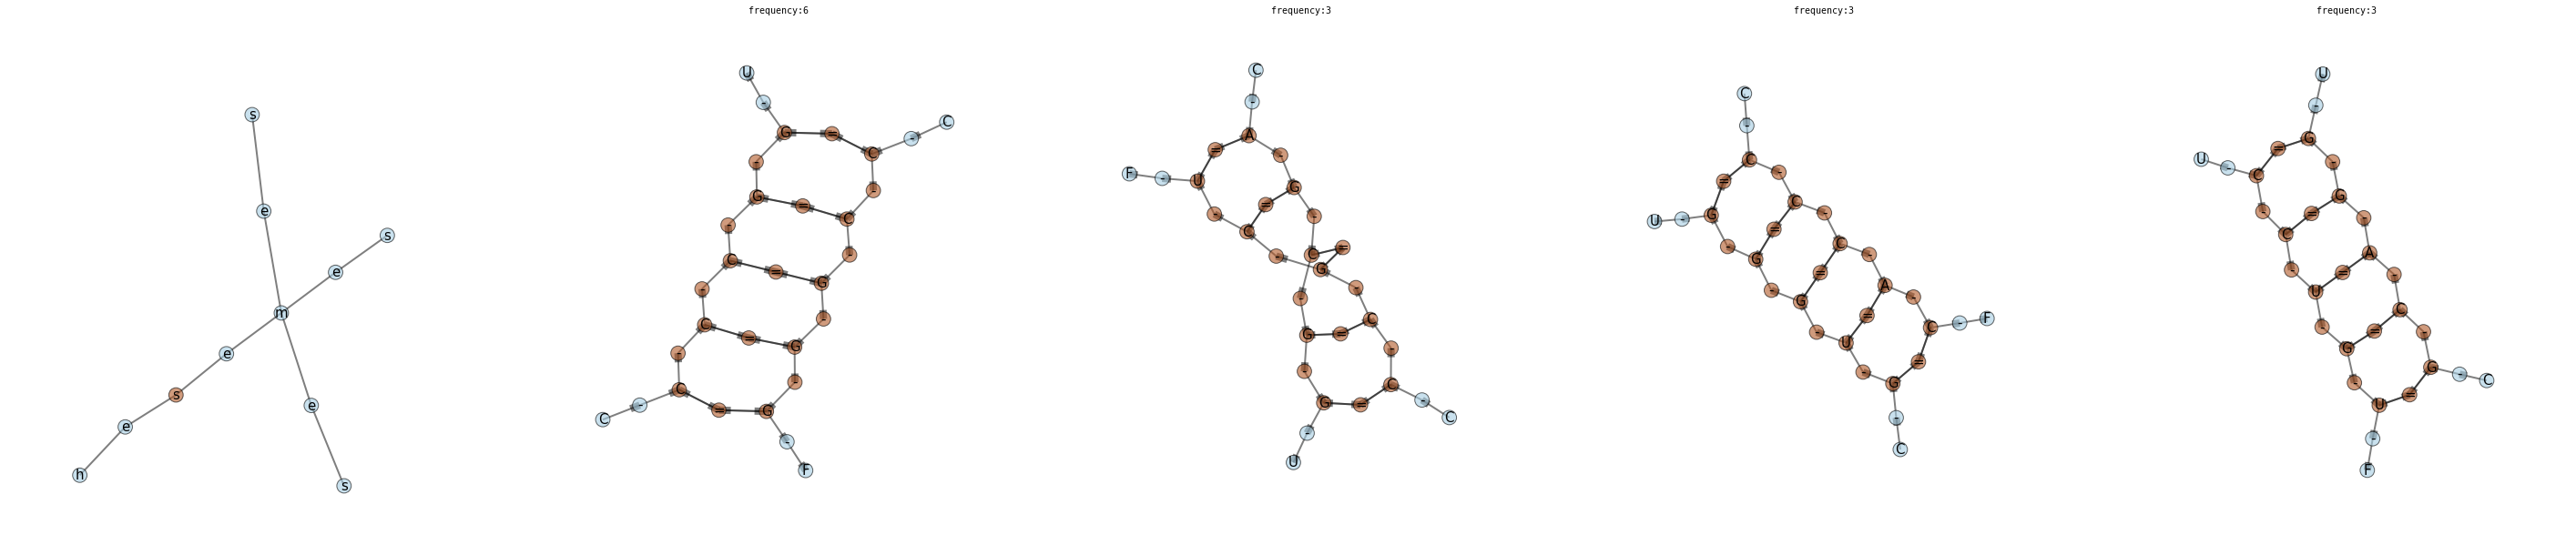

In [5]:
#draw production rules
draw.draw_grammar(sampler.lsgg.productions,n_productions=5,n_graphs_per_production=5,
                     n_graphs_per_line=6, size=10, contract=False,
                     colormap='Paired', invert_colormap=False,node_border=1,
                     vertex_alpha=0.6, edge_alpha=0.5, node_size=250, abstract_interface=True)

    

## Sample

Graph id: 66
going to draw


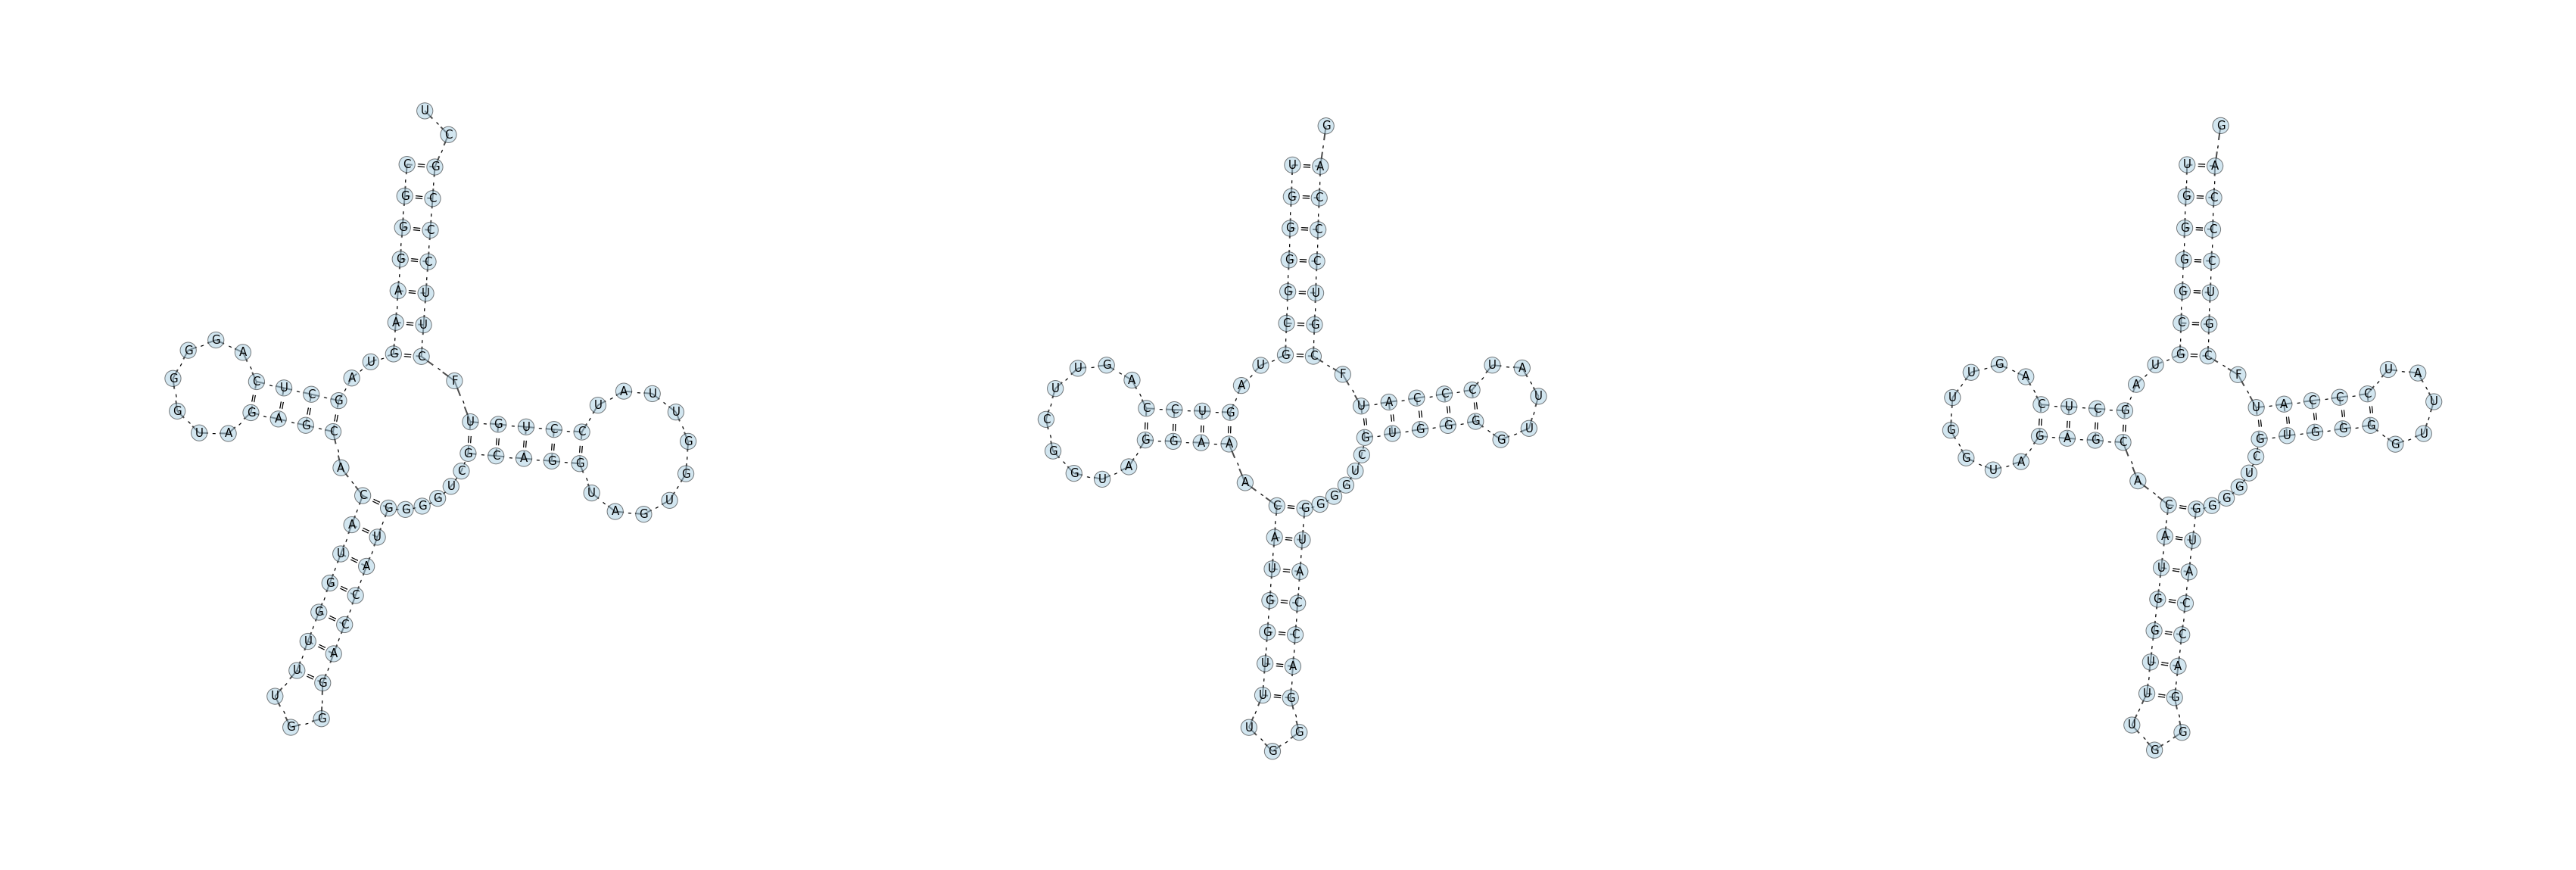

Graph id: 67
going to draw


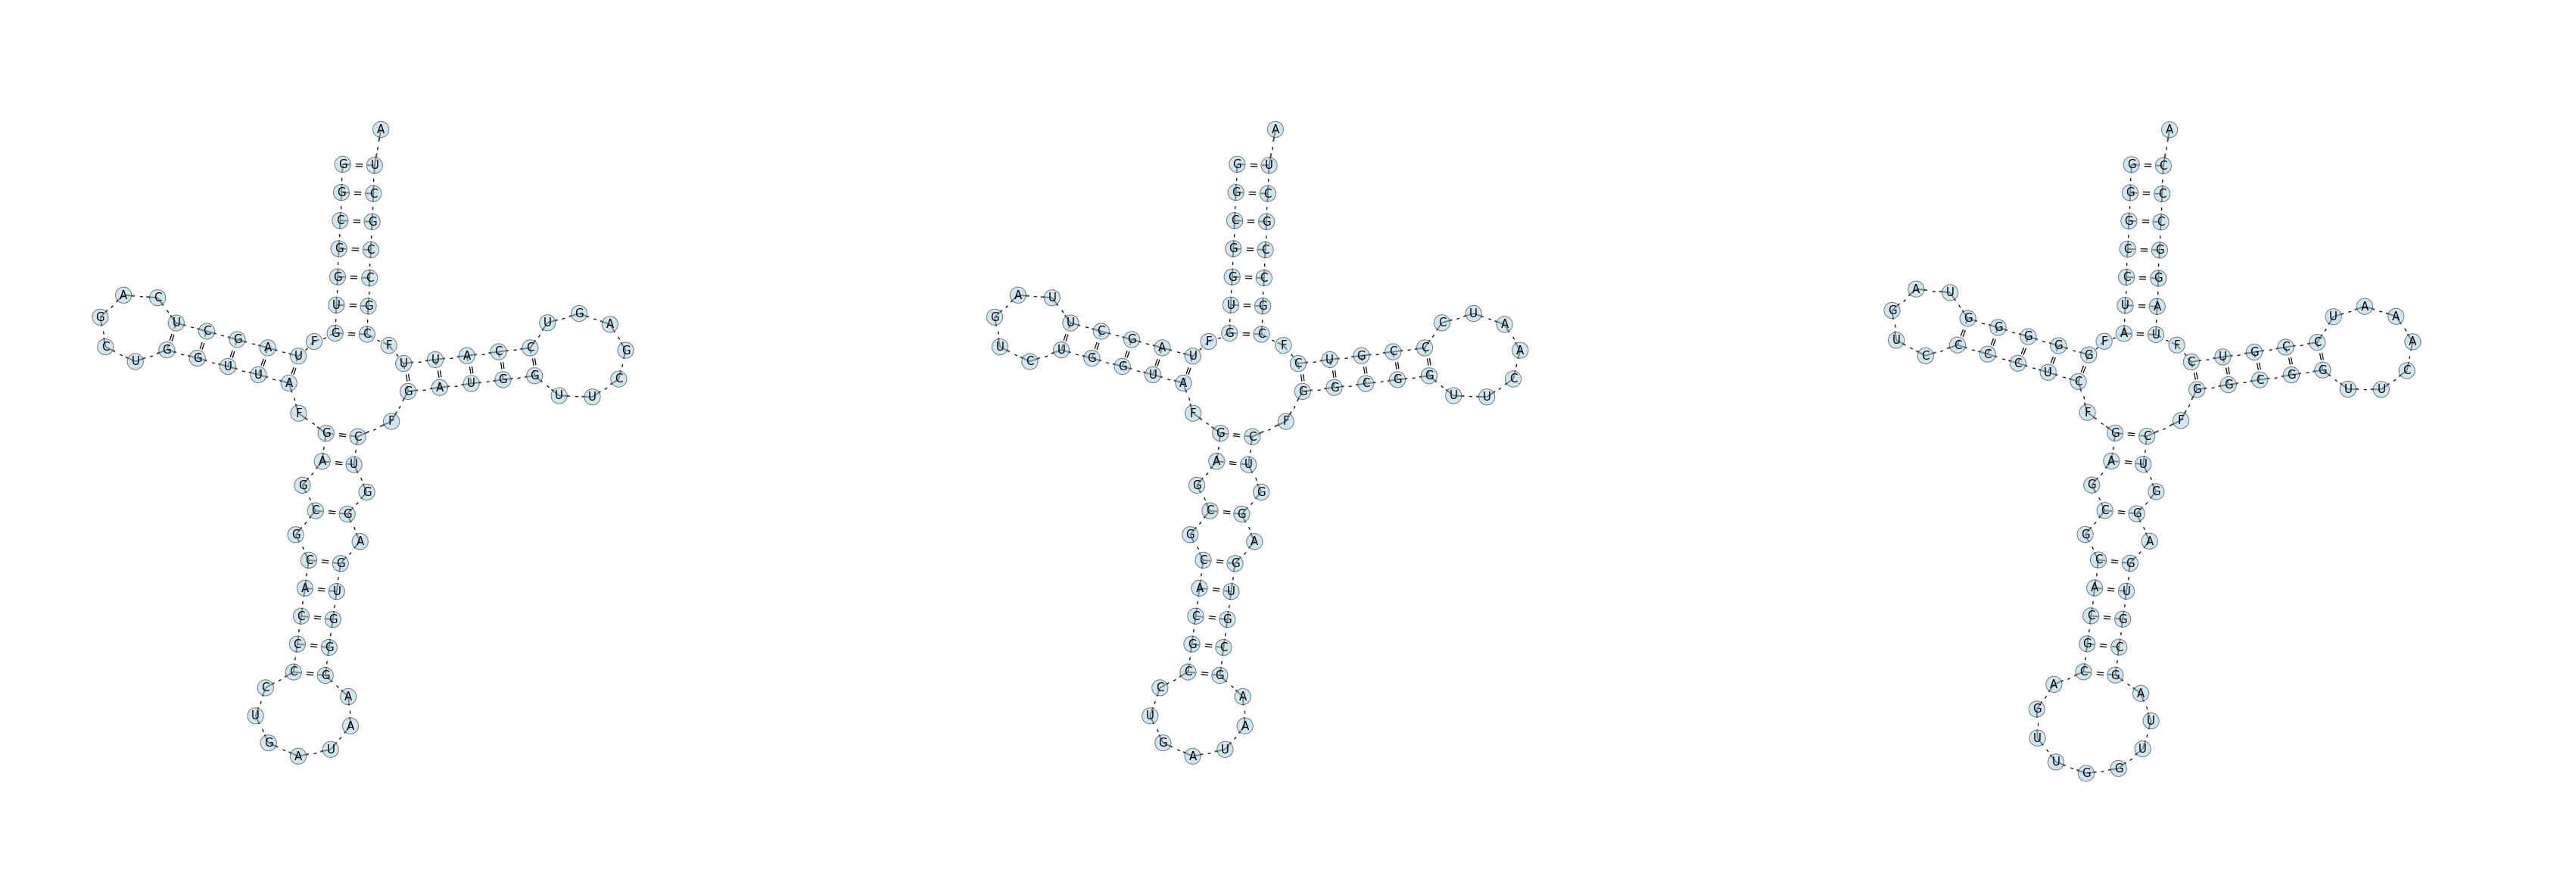

Graph id: 68
going to draw


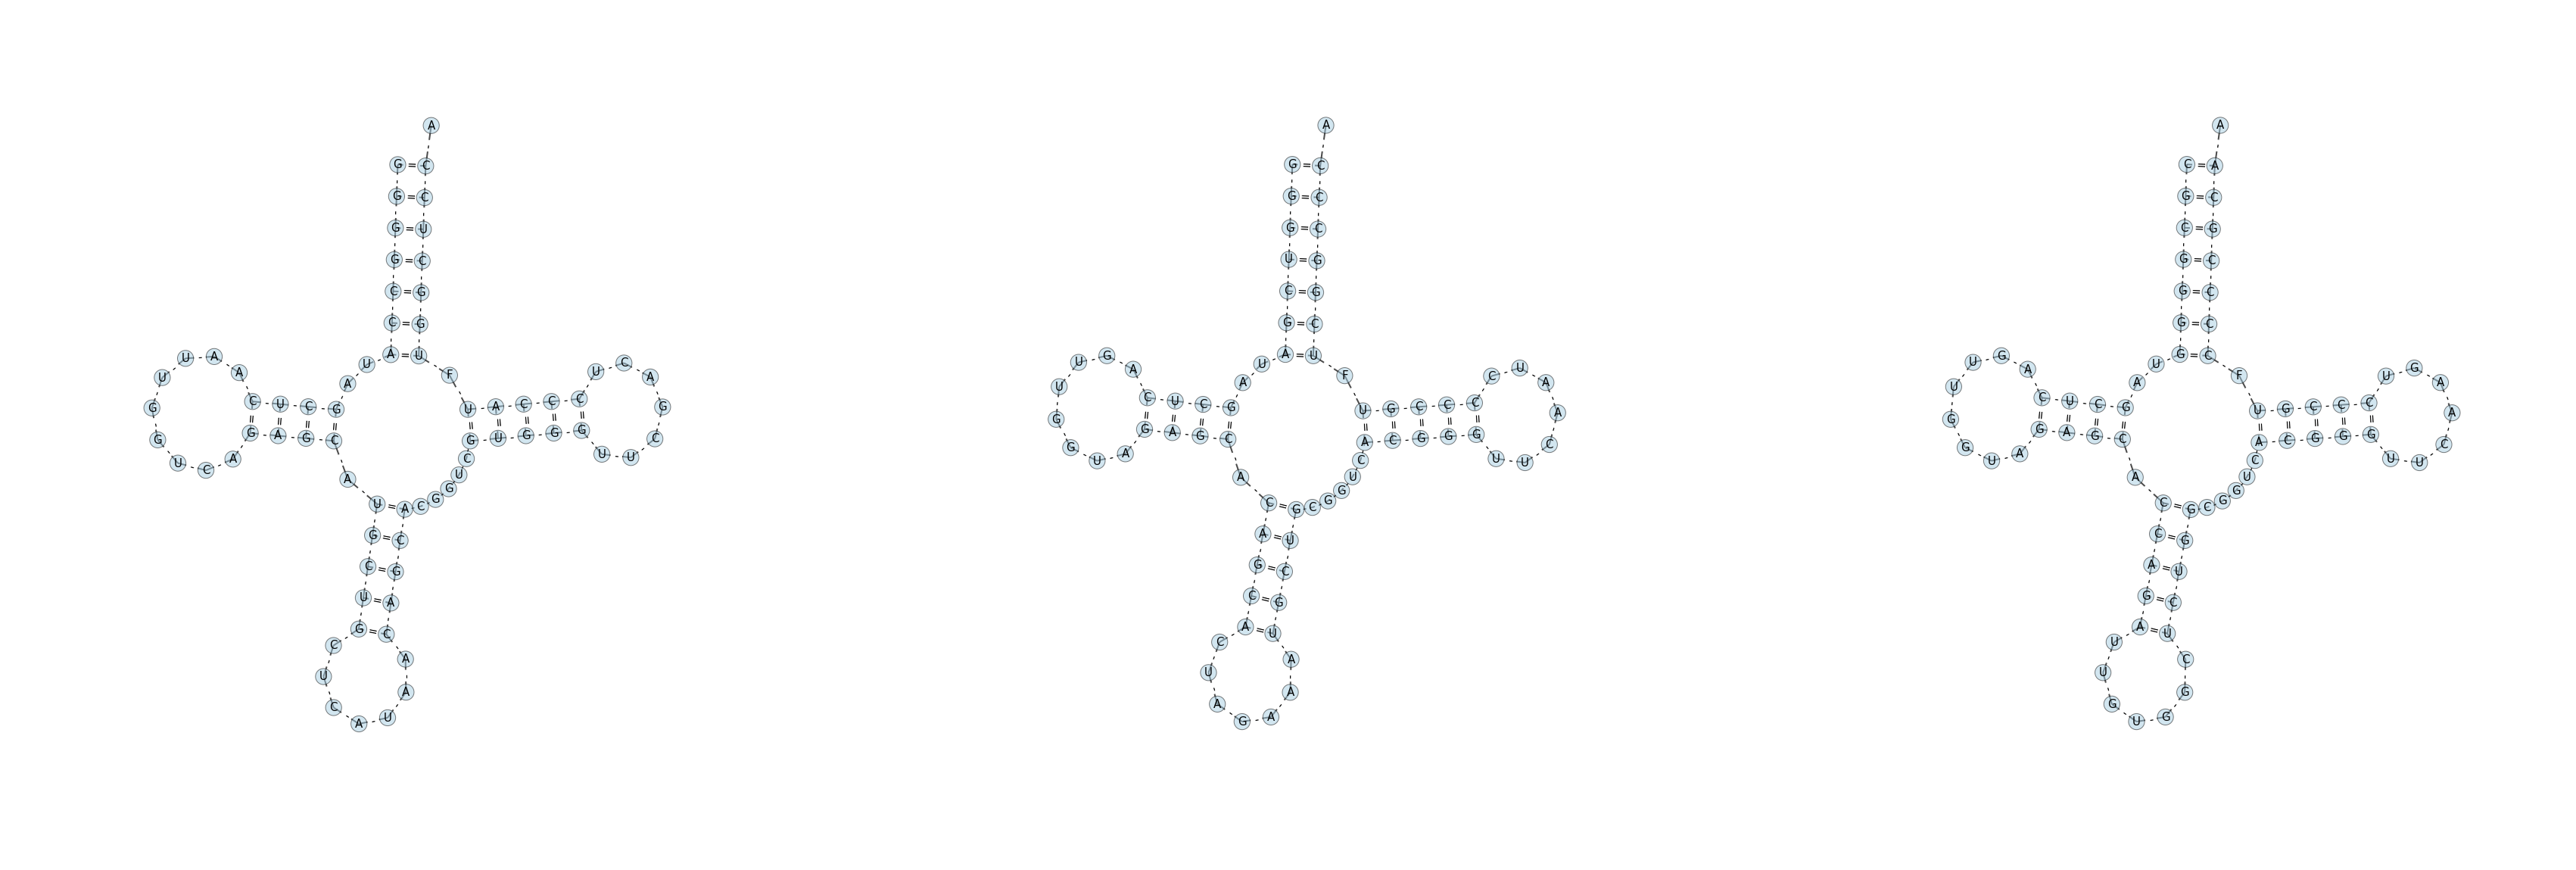

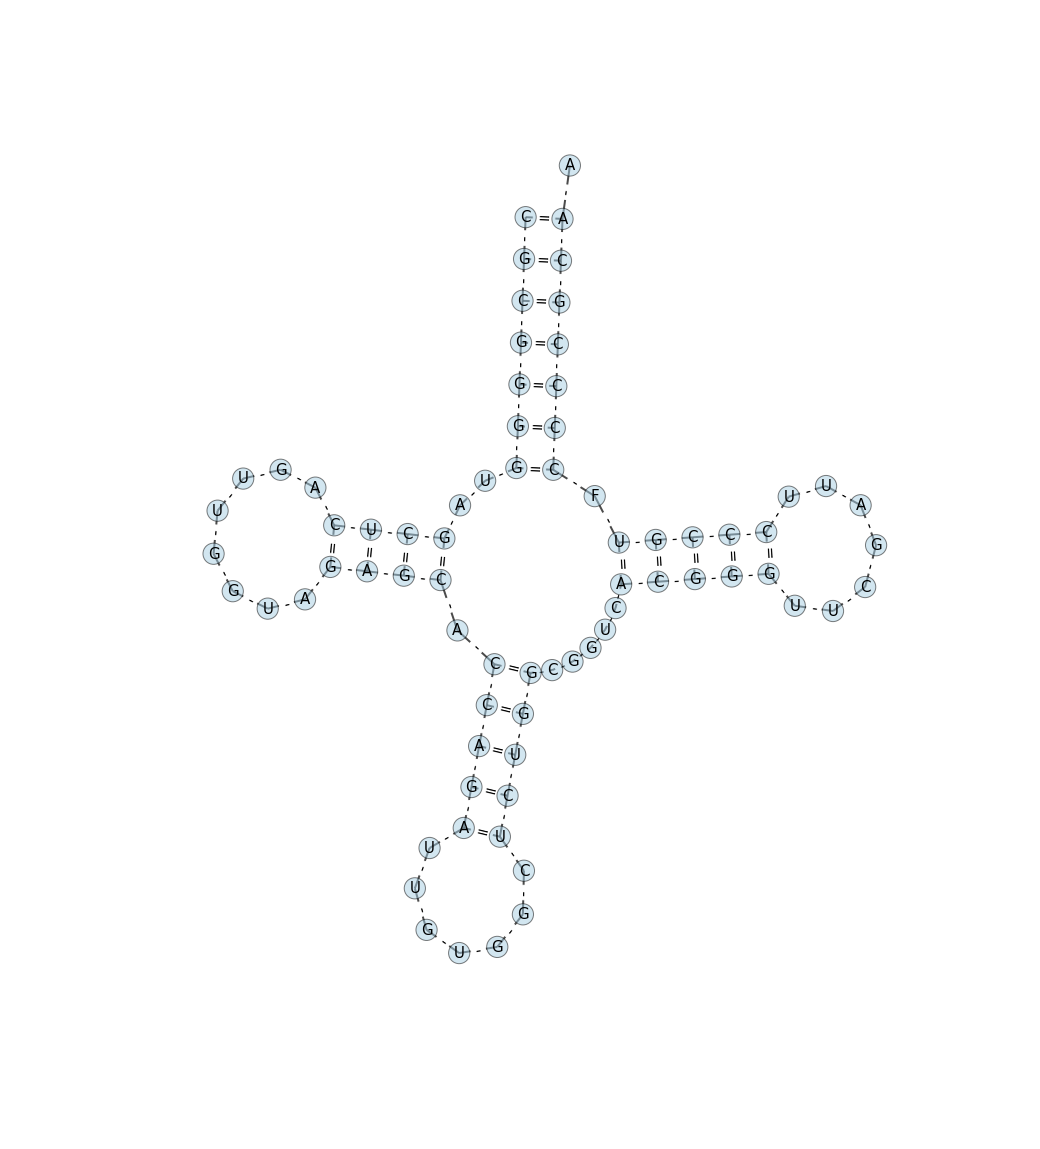

CPU times: user 19 s, sys: 2.77 s, total: 21.8 s
Wall time: 25.4 s


In [6]:
%%time
import graphlearn.utils.draw as draw
import graphlearn.abstract_graphs.RNA as rna
from graphlearn.graphlearn import Sampler as GLS
import itertools

# parameters and data
sequences = get_sequences(withoutnames=True)
id_start=66
id_end=id_start+3
sequences = sequences[id_start:id_end]
n_steps=50


graphs = sampler.sample(sequences,
                        n_samples=3,
                        batch_size=1,
                        n_steps=n_steps,
                        n_jobs=1,
                        quick_skip_orig_cip=True,
                        probabilistic_core_choice=True,
                        burnin=0,
                        improving_threshold=0.7,
                        improving_linear_start=0.2,
                        max_size_diff=20,
                        accept_min_similarity=0.65,
                        select_cip_max_tries=30,
                        keep_duplicates=False,
                        include_seed=True,
                        backtrack=10,
                        monitor=True)


from eden.modifier.graph.vertex_attributes import colorize   
scores=[]
sequences=[]
ids=range(id_start,id_end)
for i,graphlist in enumerate(graphs):
    print 'Graph id: %d'%(ids[i])
    scores.append(sampler.monitors[i].sampling_info['score_history'])
    sequences.append(sampler.monitors[i].sampling_info['notes'])
    #path_graphs = colorize(graphlist,
    #                       output_attribute = 'color_level', 
    #                       labels = ['A','U','G','C'])
    print 'going to draw'
    draw.graphlearn(graphlist,
                           n_graphs_per_line=3, size=20, contract=True,
                           colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='color_level',
                           vertex_alpha=0.5, edge_alpha=0.7, node_size=450,edge_label='label', layout="RNA")


## draw the score history for each of the graphsv

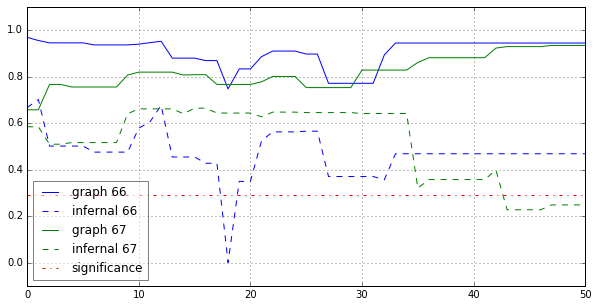

In [7]:

colors=['b','g','r','c','m','y','k','w']

%matplotlib inline
from itertools import islice
import matplotlib.pyplot as plt
import numpy as np
step=1
num_graphs_per_plot=2
num_plots=np.ceil([len(scores)/num_graphs_per_plot])
for i in range(num_plots):
    plt.figure(figsize=(10,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
        data = list(islice(score,None, None, step))
        plt.plot(data,ls='-',color=colors[j], label='graph %d'%(j+i*num_graphs_per_plot+id_start))

        # okok now we need to add the infernal evaluation
        seqs=sequences[i*num_graphs_per_plot+j]
        seqs=seqs.split('n')
        
        # SEQUENCES STILL CONTAIN F, ALSO THERE ARE ERRORMESSAGES AT THE END OF INFO
        #seqs=seqs[:-1]
    
        #print seqs
        data2= rna.infernal_checker(seqs,cmfile='../rf00005.cm')
        #print data2,seqs
        plt.plot(data2,ls='--',color=colors[j], label='infernal %d'%(j+i*num_graphs_per_plot+id_start))
    plt.plot([0.29]*len(data2),ls='-.',color='r', label='significance') #| '-' | '--' | '-.' | ':' | 'None' | ' ' |
    plt.legend(loc='lower left',framealpha=0.5)
    plt.grid()
    plt.ylim(-0.1,1.1)
    plt.show()